# Seq2Seq Model

Importing necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import time
import string
import re
import os
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_text as tf_text
import matplotlib.pyplot as plt

Now we load the data from json file and create a pandas data frame.
<br> 
After deleting duplicates the size of dataset was reduced from 7000-6971.
<br> 
I have also changed both the questions and answers to Upper Case.

In [2]:
df = pd.read_json('https://raw.githubusercontent.com/AJ6546/CE888/main/Assignment_1/train_spider.json', orient='records')
cols = ['question','query']
data=df[cols]
data=data.drop_duplicates()

#Changing Everything to Uppercase
data['query']=data['query'].str.upper()
data['question']=data['question'].str.upper()

data=data.drop_duplicates()
data.head()

,question,query
0,HOW MANY HEADS OF THE DEPARTMENTS ARE OLDER TH...,SELECT COUNT(*) FROM HEAD WHERE AGE > 56
1,"LIST THE NAME, BORN STATE AND AGE OF THE HEADS...","SELECT NAME , BORN_STATE , AGE FROM HEAD ORD..."
2,"LIST THE CREATION YEAR, NAME AND BUDGET OF EAC...","SELECT CREATION , NAME , BUDGET_IN_BILLIONS ..."
3,WHAT ARE THE MAXIMUM AND MINIMUM BUDGET OF THE...,"SELECT MAX(BUDGET_IN_BILLIONS) , MIN(BUDGET_I..."
4,WHAT IS THE AVERAGE NUMBER OF EMPLOYEES OF THE...,SELECT AVG(NUM_EMPLOYEES) FROM DEPARTMENT WHER...


Preparing Dataset 1
<br>
Here I have set some often used seantics in sql to different lists and created seperate datasets with those. I think this would give us a view on how the attention model would work on a broad NLSQL model where we have all different types of queries

In [3]:
def checkIfStringInQuery(lst):
    df1= pd.DataFrame(columns=['query', 'question'])
    for s in lst:
        df1=pd.concat([df1,data.loc[data['query'].str.contains(s, case=False)]],ignore_index=True, sort=False)
    return df1.drop_duplicates().reset_index()

select=("DISINCT", "INTO","TOP")
condi=("WHERE","BETWEEN","IN","LIKE","<",">","==","!=",">=","<=","<>","%")
logical=("AND", "OR", "NOT")
math=("\+","-","\*","\/")
order=("Order By","ASC","DESC")
joins=("JOIN","LEFT JOIN","RIGHT JOIN","FULL JOIN","SELF JOIN", "INNER JOIN", "ON","UNION","AS")
grps=("GROUP BY", "HAVING")
fns=("COUNT","MIN","MAX","AVG","SUM")
case=("CASE","THEN","WHEN")
constraint=("UNIQUE","NOT NULL","NULL")

df_select=checkIfStringInQuery(select)[cols] #length 31
df_condi=checkIfStringInQuery(condi)[cols] #length 5539
df_logical=checkIfStringInQuery(logical)[cols] #length 3740 
df_math=checkIfStringInQuery(math)[cols] #length 2193
df_order=checkIfStringInQuery(order)[cols] #length 1777
df_joins=checkIfStringInQuery(joins)[cols] #length 4332
df_grps=checkIfStringInQuery(grps)[cols] #length 1773
df_fns=checkIfStringInQuery(fns)[cols] #length 3633
df_case=checkIfStringInQuery(case)[cols] #length 4
df_constraint=checkIfStringInQuery(constraint)[cols] #length 17

Displaying Different groups by length

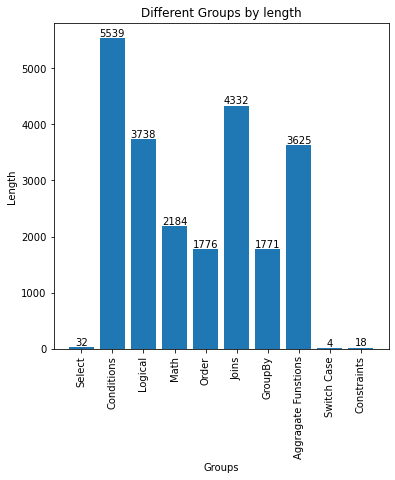

In [4]:
groups = ['Select','Conditions','Logical', 'Math', 'Order', 'Joins', 'GroupBy','Aggragate Funstions', 'Switch Case',
       'Constraints']
length =[len(df_select),len(df_condi), len(df_logical), len(df_math), len(df_order),
        len(df_joins), len(df_grps), len(df_fns), len(df_case), len(df_constraint)]

plt.rcParams["figure.figsize"]=6,6
bar_plot = plt.bar(groups, length)
plt.xlabel('Groups')
plt.xticks(groups, rotation=90)
plt.ylabel('Length')
plt.title('Different Groups by length')
def autolabel(rects):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1*height,
                length[idx],
                ha='center', va='bottom', rotation=0)
autolabel(bar_plot)
plt.savefig('Different Groups by length.png')
plt.show()


Now we set our dataset 1 using the different dataframes defined above
<br>
We use comlete df_select, df_case, df_constraints as there is only a few data
<br>
for the rest we take 5% as this was the lowest number to give dataset with instances abve and close to 1000
<br>
We remove duplicates and select 1000 instance randomly from this.
<br>
I have used random_state = 1 througout the process

In [5]:
#Keeping all the data from df_select, df_case, df_constraints as they are smaller in length
df_final=pd.concat([df_select.copy(),df_constraint,df_case],ignore_index=True, sort=False) 
df_final=df_final.drop_duplicates()
df_final

,question,query
0,SHOW THE MEDICINE NAMES AND TRADE NAMES THAT C...,"SELECT NAME , TRADE_NAME FROM MEDICINE EXCEPT..."
1,WHAT ARE THE MEDICINE AND TRADE NAMES THAT CAN...,"SELECT NAME , TRADE_NAME FROM MEDICINE EXCEPT..."
2,FIND THE DISTINCT DRIVER ID AND THE STOP NUMBE...,"SELECT DISTINCT DRIVERID , STOP FROM PITSTOPS..."
3,WHAT IS THE ID AND STOP NUMBER FOR EACH DRIVER...,"SELECT DISTINCT DRIVERID , STOP FROM PITSTOPS..."
4,FIND THE DISTINCT DRIVER ID OF ALL DRIVERS THA...,"SELECT DISTINCT DRIVERID , STOP FROM PITSTOPS..."
5,WHAT ARE THE DIFFERENT IDS AND STOP DURATIONS ...,"SELECT DISTINCT DRIVERID , STOP FROM PITSTOPS..."
6,"WHAT ARE THE DRIVERS' FIRST, LAST NAMES AND ID...","SELECT T1.FORENAME , T1.SURNAME , T1.DRIVERI..."
7,"WHAT ARE THE DRIVERS' FIRST NAMES,LAST NAMES, ...","SELECT T1.FORENAME , T1.SURNAME , T1.DRIVERI..."
8,WHAT ARE THE DRIVERS' LAST NAMES AND ID WHO HA...,"SELECT T1.SURNAME , T1.DRIVERID FROM DRIVERS ..."
9,WHAT ARE THE LAST NAMES AND IDS OF ALL DRIVERS...,"SELECT T1.SURNAME , T1.DRIVERID FROM DRIVERS ..."


In [6]:
perc = 0.05
df_final=pd.concat([df_final.copy(),df_condi.sample(frac=perc, random_state=1),
                    df_logical.sample(frac=perc, random_state=1),
                   df_math.sample(frac=perc,random_state=1),df_order.sample(frac=perc,random_state=1),
                   df_joins.sample(frac=perc,random_state=1),df_grps.sample(frac=perc,random_state=1),
                   df_fns.sample(frac=perc,random_state=1)],ignore_index=True, sort=False).drop_duplicates()

                
df_final = data.sample(n=1000,random_state=1).reset_index()
del df_final['index']
df_final

,question,query
0,LIST THE HARDWARE MODEL NAME FOR THE PHONES TH...,SELECT T2.HARDWARE_MODEL_NAME FROM CHIP_MODEL ...
1,"WHAT ARE THE MAXIMUM, MINIMUM AND AVERAGE HOME...","SELECT MAX(HOME_GAMES) , MIN(HOME_GAMES) , A..."
2,WHICH CATALOG CONTENT HAS THE HIGHEST HEIGHT? ...,SELECT CATALOG_ENTRY_NAME FROM CATALOG_CONTENT...
3,FIND THE NAMES OF CUSTOMERS WHO EITHER HAVE AN...,SELECT DISTINCT T2.CUSTOMER_DETAILS FROM POLIC...
4,"FOR EACH DISTINCT TEST RESULT, FIND THE NUMBER...","SELECT TEST_RESULT , COUNT(*) FROM STUDENT_TE..."
...,...,...
995,WHAT IS THE NAMES OF MOVIES WHOSE CREATED YEAR...,SELECT TITLE FROM MOVIE WHERE YEAR > (SELECT...
996,WHAT IS DETAIL OF THE STUDENT WHO MOST RECENTL...,SELECT T2.STUDENT_DETAILS FROM STUDENT_COURSE_...
997,FIND THE LAST NAME OF STUDENTS WHO IS EITHER F...,SELECT LNAME FROM STUDENT WHERE SEX = 'F' AN...
998,WHAT ARE ALL INFO OF STUDENTS WHO REGISTERED C...,SELECT * FROM STUDENT_COURSE_REGISTRATIONS WHE...


Selecting Dataset 2. Here we only choose instances where the query has a where condition and a Join cloause. This kind of narrows down the problem and we only focus on 1 type oof uestion.

In [7]:
def DataSetWith1JoinAndWhere():
    df1= pd.DataFrame(columns=['query', 'question'])
    df1=pd.concat([df1,data.loc[data['query'].str.contains('WHERE', case=False)]],ignore_index=True, sort=False)
    df2= pd.DataFrame(columns=['query', 'question'])
    for x in range(len(df1)):
        if(df1.loc[x]['query'].count('JOIN')==1):
            df2=df2.append(df1.loc[x])
    return df2.drop_duplicates().reset_index()
df_final2=DataSetWith1JoinAndWhere()[cols].sample(n=1000,random_state=1).reset_index()
del df_final2['index']

Cleaning The Data
<br> I have decided toremove Table notations like T1,T2... used we can add this back after the prediction is done. These are just paceholders and doesn't really mean anything.
<br> I have also removed punctuation fron Questions and changed short forms like What's to What is, So it is easier for the model to predict

In [8]:
#Cleaning Questions and Queries

def clean_text(text):
    text = text.upper()
    text = re.sub(r"WHATS'S", "WHAT IS", text)
    text = re.sub(r"WHERE'S", "WHERE IS", text)
    text = re.sub(r"\'LL", " WILL", text)
    text = re.sub(r"\'VE", " HAVE", text)
    text = re.sub(r"\'RE", " ARE", text)
    text = re.sub(r"\'D", " WOULD", text)
    text = re.sub(r"WON'T", "WILL NOT", text)
    text = re.sub(r"CAN'T", "CANNOT", text)
    text = re.sub(r"[\"#/@;:{}~|.?,]", "", text)
    for i in range(1,10):   
        text = re.sub(r"\ T"+str(i), " ", text)
    return text

clean_questions=[]
for question in df_final['question']:
    clean_questions.append(clean_text(question))

clean_queries=[]
for query in df_final['query']:
    clean_queries.append(clean_text(query))

Tokenizing is used to change the questions and queries to vector format. I have added 2 to Vocabulary size of both Questions and Queries to represent start of sentence and end of sentence added in subsequent step.
<br> These vectors are saved in inputs and outputs respectively.
<br> I have set the Max_length to 40 and removed all the instances where the queries or questions exceed this limit.

In [9]:
#Tokenizing
tokenizer_questions = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(clean_questions,
                                                                                target_vocab_size=2**13)
tokenizer_queries = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(clean_queries,
                                                                                target_vocab_size=2**13)
        
VOCAB_SIZE_QUESTIONS = tokenizer_questions.vocab_size+2
VOCAB_SIZE_QUERIES = tokenizer_queries.vocab_size+2

inputs =[[VOCAB_SIZE_QUESTIONS-2]+tokenizer_questions.encode(sentence)+[VOCAB_SIZE_QUESTIONS-1]
         for sentence in clean_questions]

outputs =[[VOCAB_SIZE_QUERIES-2]+tokenizer_queries.encode(sentence)+[VOCAB_SIZE_QUERIES-1]
         for sentence in clean_queries]

MAX_LENGTH=40
idx_to_remove =[count for count, sent in enumerate(inputs) if len(sent)>MAX_LENGTH]
for idx in reversed(idx_to_remove):
    del inputs[idx]
    del outputs[idx]
    
idx_to_remove =[count for count, sent in enumerate(outputs) if len(sent)>MAX_LENGTH]
for idx in reversed(idx_to_remove):
    del inputs[idx]
    del outputs[idx]
    
len(inputs)

968

We uuse keras pad sequence to pad all the questions or queries which had length shorter than 40 to set all the inputs and outputs to have the same length.

In [ ]:
#Padding Inputs and Outputs
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                                  value=0,padding='post',
                                                                  maxlen=MAX_LENGTH)
outputs = tf.keras.preprocessing.sequence.pad_sequences(outputs,
                                                                  value=0,padding='post',
                                                                  maxlen=MAX_LENGTH)

Creating Dataset and Splitting it to train-validation-test. I have chosen a 70-15-15 split

In [ ]:
dataset=tf.data.Dataset.from_tensor_slices((inputs,outputs))

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = int(0.15 * len(dataset))

#dataset = dataset.shuffle()
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

Following the same Cleaning-Tokenizing-Padding Step for dataset 2

In [ ]:
#Cleaning Questions and Queries
clean_questions2=[]
for question in df_final2['question']:
    clean_questions2.append(clean_text(question))

clean_queries2=[]
for query in df_final2['query']:
    clean_queries2.append(clean_text(query))

#Tokenizing
tokenizer_questions2 = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(clean_questions2,
                                                                                target_vocab_size=2**13)
tokenizer_queries2 = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(clean_queries2,
                                                                                target_vocab_size=2**13)
        
VOCAB_SIZE_QUESTIONS2 = tokenizer_questions2.vocab_size+2
VOCAB_SIZE_QUERIES2 = tokenizer_queries2.vocab_size+2

inputs2 =[[VOCAB_SIZE_QUESTIONS2-2]+tokenizer_questions2.encode(sentence)+[VOCAB_SIZE_QUESTIONS2-1]
         for sentence in clean_questions2]

outputs2 =[[VOCAB_SIZE_QUERIES2-2]+tokenizer_queries2.encode(sentence)+[VOCAB_SIZE_QUERIES2-1]
         for sentence in clean_queries2]

MAX_LENGTH2=40
idx_to_remove2 =[count for count, sent in enumerate(inputs2) if len(sent)>MAX_LENGTH2]
for idx in reversed(idx_to_remove2):
    del inputs2[idx]
    del outputs2[idx]
    
idx_to_remove2 =[count for count, sent in enumerate(outputs2) if len(sent)>MAX_LENGTH2]
for idx in reversed(idx_to_remove2):
    del inputs2[idx]
    del outputs2[idx]
    
len(inputs2)

In [ ]:
#Padding Inputs and Outputs
inputs2 = tf.keras.preprocessing.sequence.pad_sequences(inputs2,
                                                                  value=0,padding='post',
                                                                  maxlen=MAX_LENGTH2)
outputs2 = tf.keras.preprocessing.sequence.pad_sequences(outputs2,
                                                                  value=0,padding='post',
                                                                  maxlen=MAX_LENGTH2)

Creating dataset 2 and splitting to train-validation-test. I have again chose 70-15-15 % split

In [ ]:
dataset2=tf.data.Dataset.from_tensor_slices((inputs2,outputs2))

train_size2 = int(0.7 * len(dataset2))
val_size2 = int(0.15 * len(dataset2))
test_size2 = int(0.15 * len(dataset2))


train_dataset2 = dataset2.take(train_size2)
test_dataset2 = dataset2.skip(train_size2)
val_dataset2 = test_dataset2.skip(test_size2)
test_dataset2 = test_dataset2.take(test_size2)

In [ ]:
print(VOCAB_SIZE_QUESTIONS)
print(VOCAB_SIZE_QUERIES)
print(VOCAB_SIZE_QUESTIONS2)
print(VOCAB_SIZE_QUERIES2)